<a href="https://colab.research.google.com/github/PeterDomanski/Introductions/blob/main/Deep_Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction to Deep Visualization**

Modern, state-of-the-art Deep NN are highly non-linear models with millions of parameters due to their complex structure and high-dimensional data spaces. It is difficult to provide information about what is responsible for a certain prediction. Because of this lack of transparency, Deep NN are often referred to as **black-box models**. 

**Deep Visualizations** aim to
*   build trust in predictions of Deep NN
*   gain insights about how NN work or do not work
*   increase the interpretability of NN
*   visualize features that are guiding a model's decision process
*   visualize and validate the decision process



Deep visualization methods generally can be distinguished into two techniques: 


1.   methods that visualize the model's discrimination rules
2.   methods that examine what could pertub the model's predictions

In the following, we focus on methods that produce visualizations in the form of **saliency maps**. Such methods belong to the first technique and aim to find and **highlight regions, features, or individual pixels** in the input image that are **most salient** for a particular output class. Therefore, the methods calculate the **gradient of the output w.r.t. the input**. The gradient gives information about how changes in pixels or within regions alter
the output value of the considered class



Here, we show two popular visualization methods that produce a **class-specific saliency map** for each input image, namely **Grad-CAM** [1] and **Integrated Gradients** [2].



#**Gradient-weighted Class Activation Mapping (Grad-CAM)**

Grad-CAM is a **class-discriminativ localization technique** that generates coarse localization maps to highlight important regions for a particular class. Grad-CAM works without making changes to the original model. Thus, Grad-CAM can help to differentiate 'stringer' from 'weaker' networks. The idea of Grad-CAM is to **visualize the importance of the feature maps**
that a (convolutional) layer learns in its kernels. Due to the hierarchical feature extraction in NN, deeper layers within the network learn
to extract high-level features that are a combination of low-level features of preceding layers. Thus, it is usually more informative to generate visualizations of the last (convolutional) layer(s).

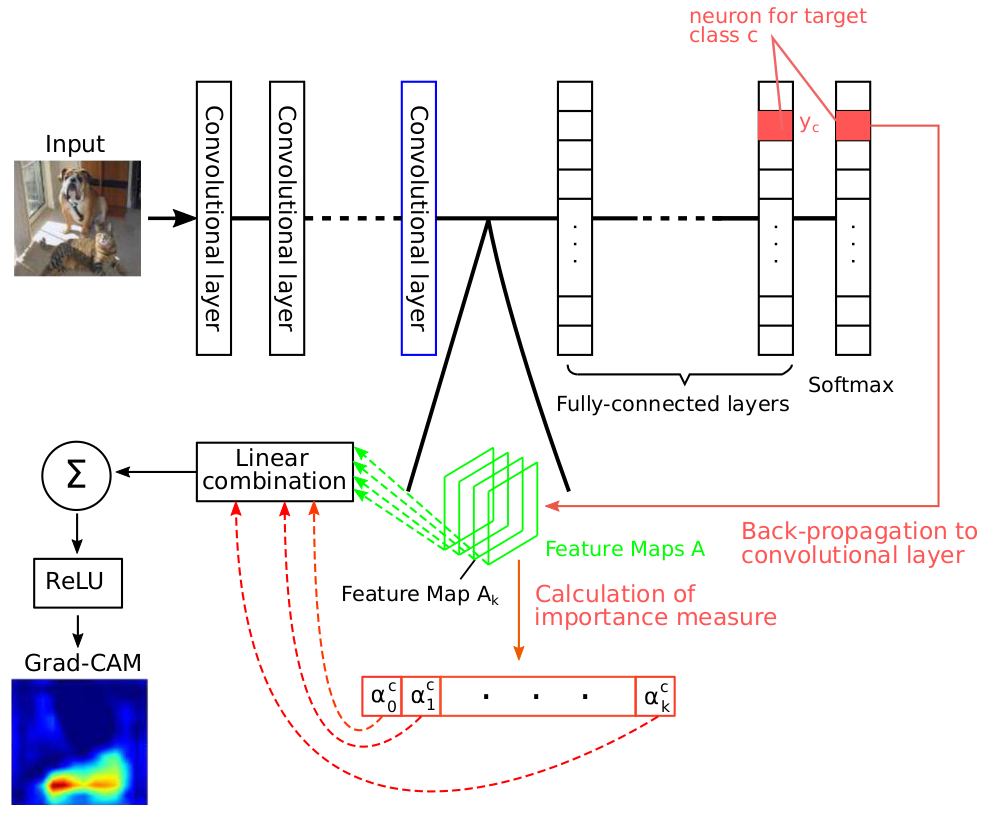

##Calculation of Grad-CAM


1.   calculate scalar importance measure $$a_k^c=\frac{1}{Z}\sum_{i=1}^{u}\sum_{j=1}^{v} \frac{\partial y^c}{\partial A_{ij}^{k}}$$
2.   weight each feature map by its importance measure and calculate sum (w: total number of feature maps ) $$ \sum_{k=1}^{w} a_{k}^{c} * A_k $$ 
3.   apply ReLU function to weighted sum $$L_{Grad-CAM}^{c}=ReLU\left[\sum_{k=1}^{w} a_k^c*A_k\right]$$



To test Grad-CAM, we train a Convolutional NN (CNN) on the MNIST data set. Thus, we first load the MNIST data set.

In [ ]:
import tensorflow as tf
%load_ext tensorboard

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# preprocess data set(s)
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)

Next, we define a CNN and train it with the MNIST (training) data set

In [ ]:
cnn_model = tf.keras.models.Sequential([
   tf.keras.layers.Input(shape=(28, 28, 1)),
   tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name="conv2d_1"),
   tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
   tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name="conv2d_2"),
   tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
   tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name="conv2d_3"),
   tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
   tf.keras.layers.Flatten(),
   tf.keras.layers.Dense(10, activation="softmax")
])

# define loss function for training the cnn
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile model -> min loss function and measure accuracy of classification
cnn_model.compile(optimizer='adam',
                  loss=loss_fn,
                  metrics=['accuracy'])

# tensorflow callback object
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs_grad_cam", 
                                                      update_freq='epoch')

# train model
cnn_model.fit(x_train, y_train, epochs=10, batch_size=128,
              callbacks=[tensorboard_callback], validation_split=0.1)


Epoch 1/10
422/422 [==============================] - 24s 57ms/step - loss: 0.7841 - accuracy: 0.7802 - val_loss: 0.0884 - val_accuracy: 0.9710
Epoch 2/10
422/422 [==============================] - 24s 56ms/step - loss: 0.0870 - accuracy: 0.9713 - val_loss: 0.0644 - val_accuracy: 0.9805
Epoch 3/10
422/422 [==============================] - 24s 57ms/step - loss: 0.0612 - accuracy: 0.9807 - val_loss: 0.0471 - val_accuracy: 0.9872
Epoch 4/10
422/422 [==============================] - 24s 56ms/step - loss: 0.0434 - accuracy: 0.9870 - val_loss: 0.0440 - val_accuracy: 0.9882
Epoch 5/10
422/422 [==============================] - 24s 56ms/step - loss: 0.0341 - accuracy: 0.9893 - val_loss: 0.0427 - val_accuracy: 0.9872
Epoch 6/10
422/422 [==============================] - 24s 56ms/step - loss: 0.0301 - accuracy: 0.9910 - val_loss: 0.0400 - val_accuracy: 0.9890
Epoch 7/10
422/422 [==============================] - 24s 57ms/step - loss: 0.0241 - accuracy: 0.9927 - val_loss: 0.0447 - val_accuracy:

Now, let us implement the Grad-CAM technique

In [ ]:
def grad_cam(model, x_test, y_test, layer_name):
  grad_cams = []
  predicted_classes = []
  for image in x_test[:32]:
      image_shape = image.shape
      image = tf.expand_dims(image, 0)
      category_index = tf.math.argmax(cnn_model(image), axis=-1)
      # output = []
      with tf.GradientTape() as g:
        # g.watch(output)
        intermediate_layer_model = tf.keras.Model(
            inputs=model.input,
            outputs=[model.get_layer(name=layer_name).output,
                     model.layers[-1].output])
        outputs = intermediate_layer_model(image)
        output, x = outputs[0], outputs[1]
        y_c = x[:, category_index.numpy()[0]: (category_index.numpy()[0]) + 1]

      target_conv_layer_grad = g.gradient(y_c, output)[0]
            
      a_k = tf.math.reduce_mean(target_conv_layer_grad, axis=(0, 1))
      output = output[0]
  
      lin_comb = a_k * output
      lin_comb = tf.math.reduce_sum(lin_comb, axis=2)  
      
      cam = tf.nn.relu(lin_comb) 
      
      cam = tf.reshape(cam, cam.numpy().shape + (1,))
      cam = tf.image.resize(cam, image_shape[: 2])
      cam = tf.reshape(cam, image_shape[: 2]).numpy()
      heatmap = cam / tf.math.reduce_max(cam)
      
      grad_cams.append(heatmap)
      predicted_classes.append(tf.squeeze(category_index).numpy())
  return grad_cams, predicted_classes

grad_cams, pred_classes = grad_cam(cnn_model, x_test, y_test, "conv2d_3")

It is time to visualize the results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


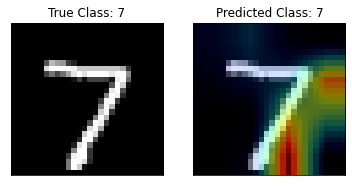

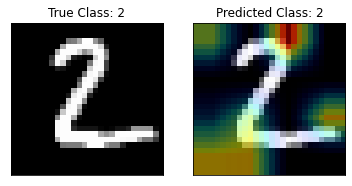

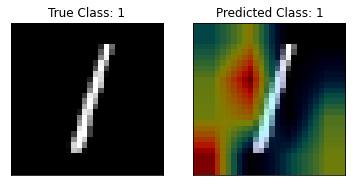

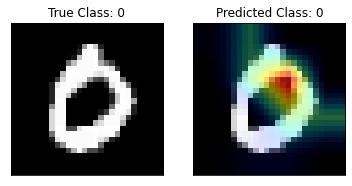

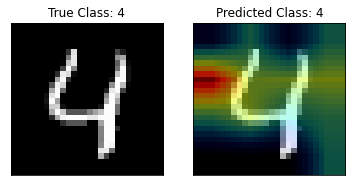

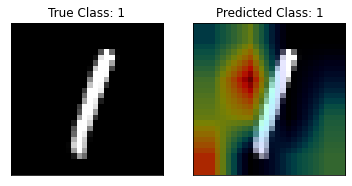

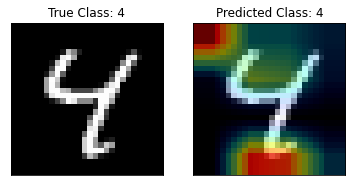

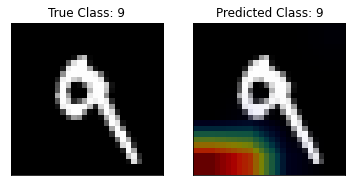

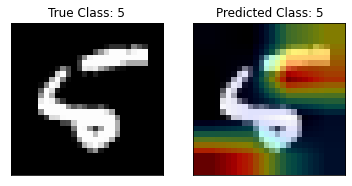

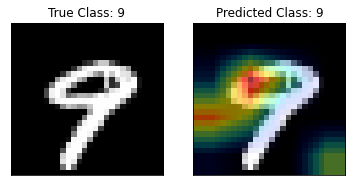

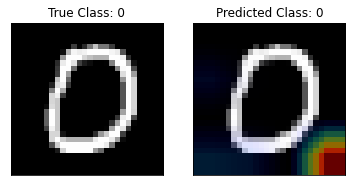

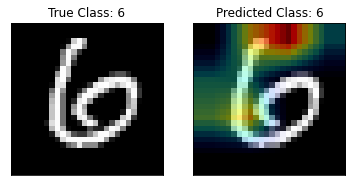

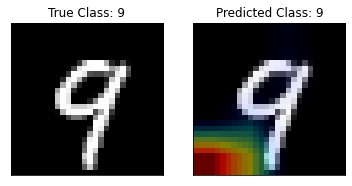

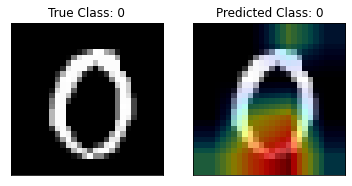

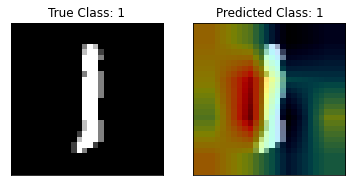

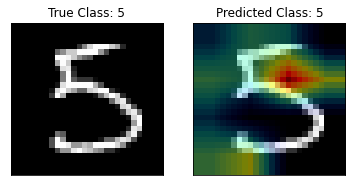

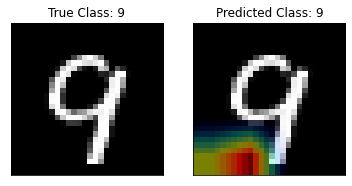

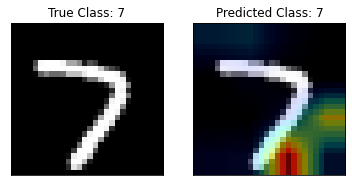

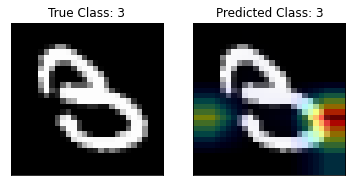

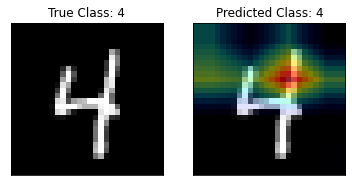

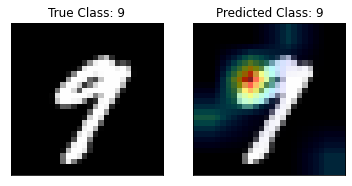

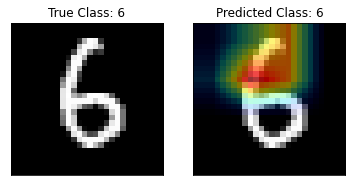

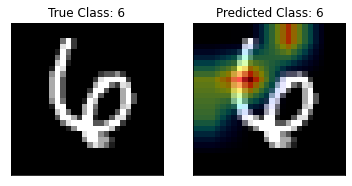

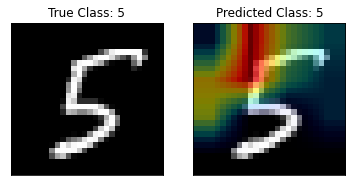

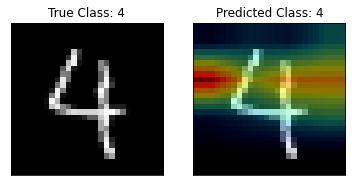

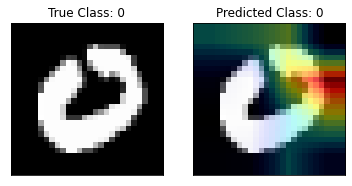

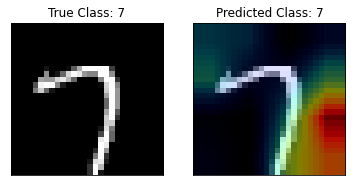

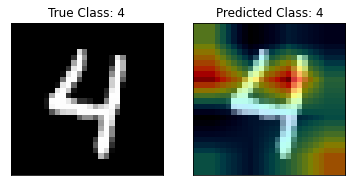

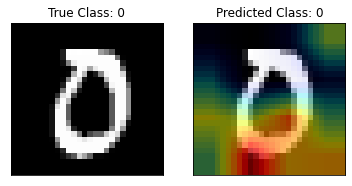

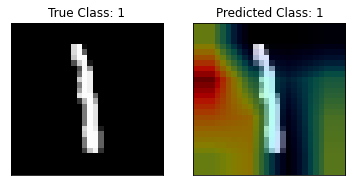

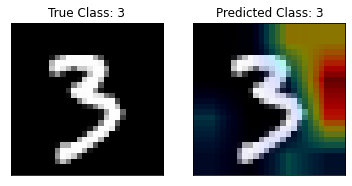

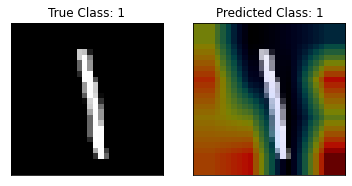

In [ ]:
import matplotlib.pyplot as plt

def visualize_grad_cam(grad_cams, x_test, y_test, pred_classes):
  for i, grad_cam in enumerate(grad_cams):
    raw_image = tf.squeeze(x_test[i])
    cm = plt.cm.jet
    colors = cm(grad_cam)
    colors[..., -1] = grad_cam
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(raw_image, cmap='gray')
    ax1.set_xticklabels([])
    ax1.set_xticks([])
    ax1.set_yticklabels([])
    ax1.set_yticks([])
    ax1.set_title('True Class: ' + str(y_test[i]))
    ax2.imshow(raw_image, cmap='gray')
    ax2.imshow(colors, alpha=0.8)
    ax2.set_title('Predicted Class: '+ str(pred_classes[i]))
    ax2.set_xticklabels([])
    ax2.set_xticks([])
    ax2.set_yticklabels([])
    ax2.set_yticks([])

visualize_grad_cam(grad_cams, x_test, y_test, pred_classes)

#**Integrated Gradients (IG)**

Similar to Grad-CAM, IG is a **class-discriminativ visualization technique** which means that it only visualize the features that are responsible for the predicted class. Moreover, IG has the following properties:

*   pixel-level visualization technique
*   attributes predictions of NN to input features
*   highlights pixels which are responsible for a particular decision
*   can be applied to any NN without changes to the original model

## Idea of IG

*   use a baseline x' to model the absence of any feature 
*   baseline x' defines a reference value for which the NN yields a neutral prediction
*   to determine the influences of individual pixels IG compares their
contribution to that of the reference value
*   example of a (natural) baseline: black image in image recognition tasks

## Calculation of IG


1.   suppose the NN is a function $F:\mathbb{R}^n \rightarrow [0, 1] $ with the input $ x \in \mathbb{R}^n $ and the baseline $ x' \in \mathbb{R}^n $ 
2.   Integrated Gradients (along the $i^{th}$ dimension): calculate the path integral of the gradients along the straight-line path from $x$ to $x'$ $$ IG(x)_i = (x_i - x'_i)\int_{\alpha=0}^1 \frac{\partial F(x'+\alpha(x-x'))}{\partial x_i} \partial \alpha$$
3.   The path integral is typically solved numerically (Riemann approximation with $m$ steps) $$ IG_i^{approx}(x)=(x_i-x'_i) \left[ \sum_{k=1}^m \frac{\partial F(x' + \frac{k}{m}(x-x'))}{\partial x_i} \right]$$






Let us implement the IG visualization technique by using the approximation formula above

In [ ]:
def integrated_gradients(model, x_test, steps=100):
  igs, predicted_classes = [], []
  for i, image in enumerate(x_test[:32]):
    baseline = tf.zeros(image.shape)
    category_index = tf.math.argmax(cnn_model(tf.expand_dims(image, 0)), axis=-1)
    predicted_classes.append(tf.squeeze(category_index).numpy())
    grads = []
    for m in range(1, steps+1):
      with tf.GradientTape() as tape:
        tape.watch(image)
        inp = baseline + (float(m)/steps)*(image-baseline)
        x = tf.squeeze(model(tf.expand_dims(inp, 0)))
        x_index = tf.argmax(x).numpy()
        x = x[tf.squeeze(category_index).numpy()]
      grad = tape.gradient(x, image)
      grads.append(grad)
    g = tf.convert_to_tensor(grads)
    avg_grads = tf.reduce_mean(g, axis=0)
    integrated_gradients = (image-baseline)*avg_grads
    igs.append(integrated_gradients)
  return igs, predicted_classes       

igs, pred_classes = integrated_gradients(cnn_model, x_test)             

Let us take a look at the generated visualizations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


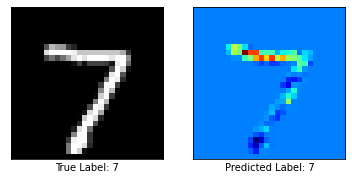

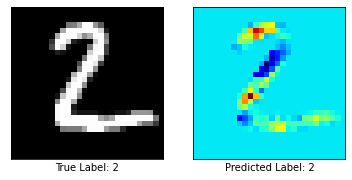

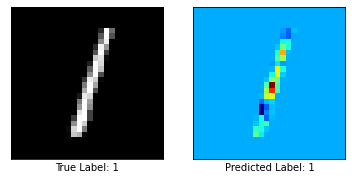

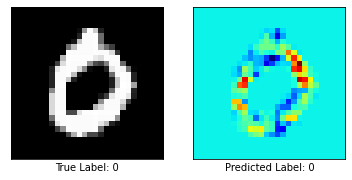

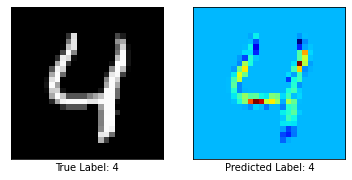

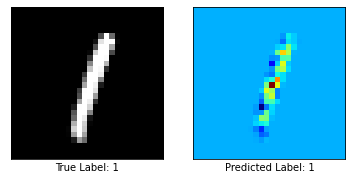

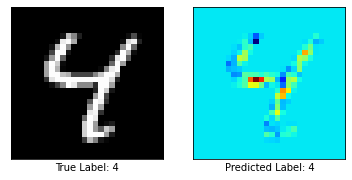

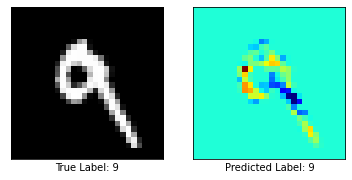

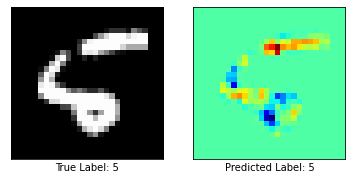

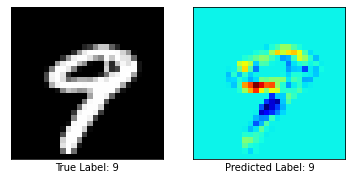

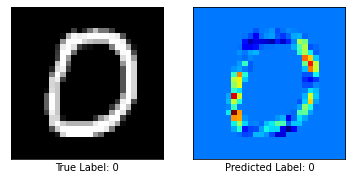

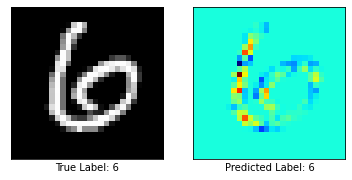

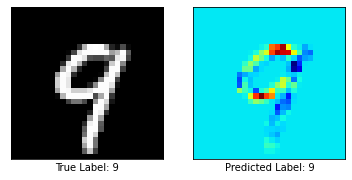

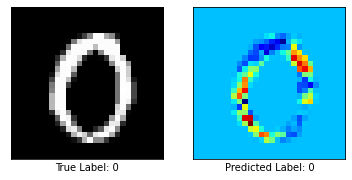

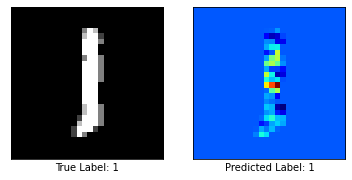

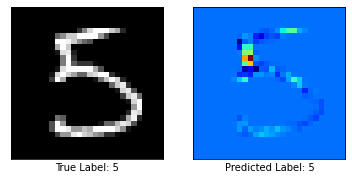

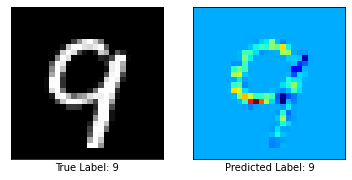

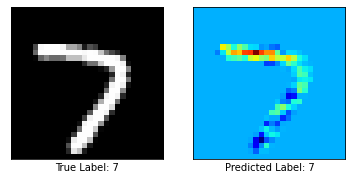

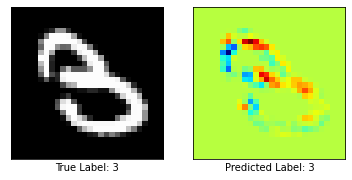

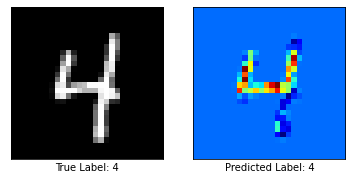

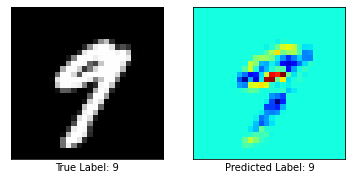

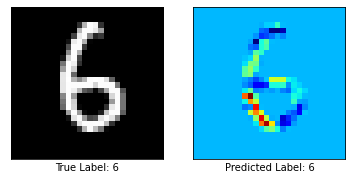

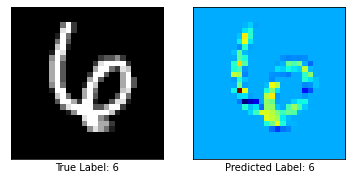

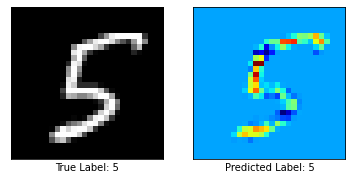

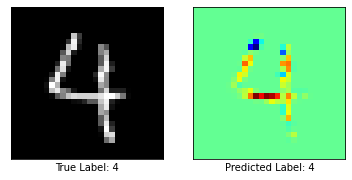

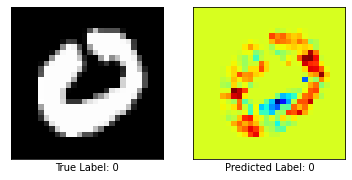

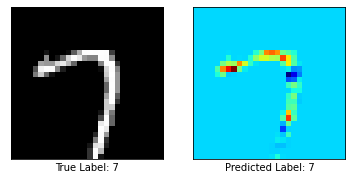

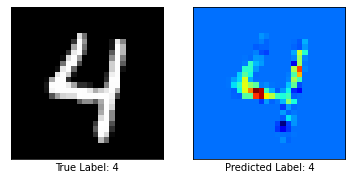

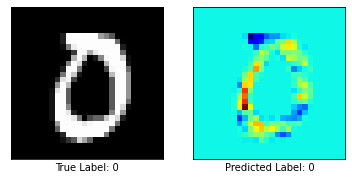

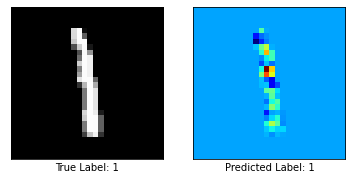

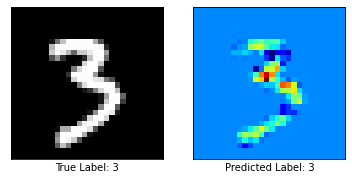

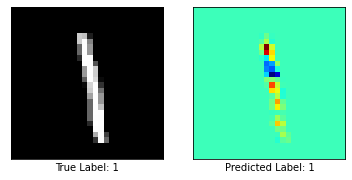

In [ ]:
import numpy as np
import matplotlib as mpl

def visualize_ig(igs, x_test, y_test, pred_classes, post_processing=False):
  for i, ig in enumerate(igs):
    # preprocessing of ig visualizations
    integrated_gradients = ig
    if post_processing:
      integrated_gradients = np.clip(integrated_gradients, 0, 1)
      integrated_gradients = np.average(integrated_gradients, axis=2)
      channel = [255,]
      flat_ig = integrated_gradients.flatten()
      ig_sum = np.sum(flat_ig)
      sorted_ig = np.sort(np.abs(flat_ig))[::-1]
      cum_sum = 100.0 * np.cumsum(sorted_ig) / ig_sum
      threshold_idx_m = np.where(cum_sum >= 0.1)[0][0]
      m = sorted_ig[threshold_idx_m]
      e = np.min(integrated_gradients)
      transformed = (1 - 0.01) * (np.abs(integrated_gradients) - e) / (m - e) + 0.01
      transformed *= np.sign(integrated_gradients)
      transformed *= (transformed >= 0.01)
      integrated_gradients = np.clip(transformed, 0.0, 1.0)
      integrated_gradients = np.expand_dims(integrated_gradients, 2) * channel 
      integrated_gradients = tf.math.divide_no_nan(
          integrated_gradients, tf.reduce_max(integrated_gradients)).numpy()

    # plot 
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(tf.squeeze(x_test[i]), cmap='gray')
    ax1.set_xlabel("True Label: " + str(y_test[i]))
    ax1.set_xticklabels([])
    ax1.set_xticks([])
    ax1.set_yticklabels([])
    ax1.set_yticks([])
    ax2.imshow(tf.squeeze(integrated_gradients), cmap='jet', 
               vmin=np.min(integrated_gradients), 
               vmax=np.max(integrated_gradients))
    ax2.set_xlabel("Predicted Label: " + str(pred_classes[i]))
    ax2.set_xticklabels([])
    ax2.set_xticks([])
    ax2.set_yticklabels([])
    ax2.set_yticks([])

visualize_ig(igs, x_test, y_test, pred_classes, post_processing=False)

Now, with additional preprocessing that highlights the positive parts of IGs (parts that increase the probability of a certain class)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


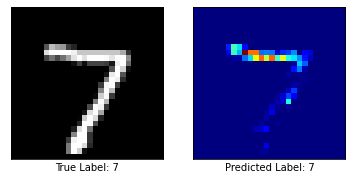

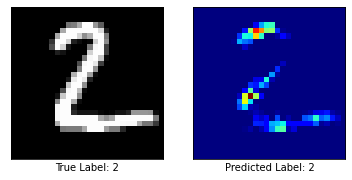

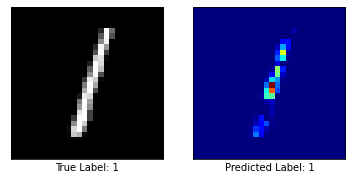

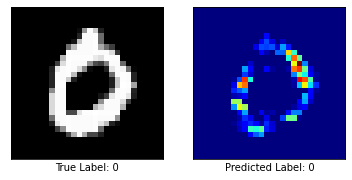

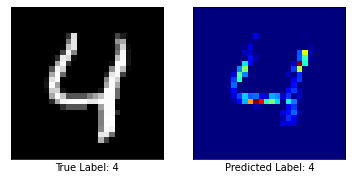

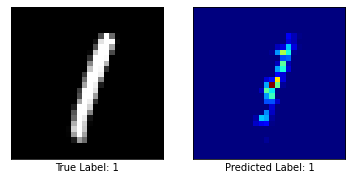

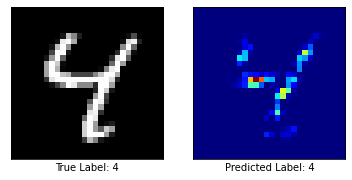

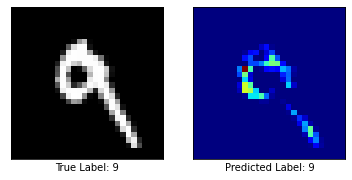

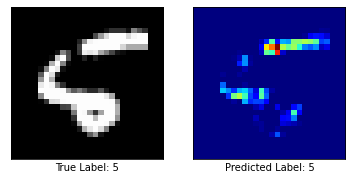

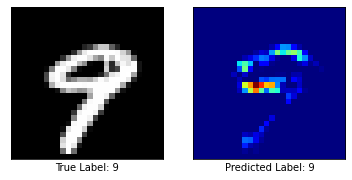

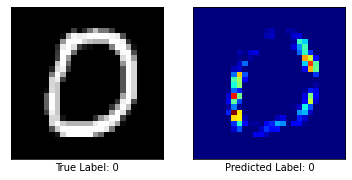

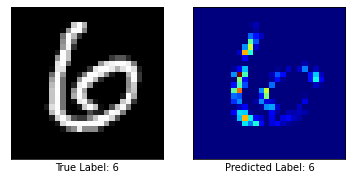

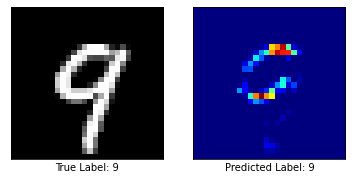

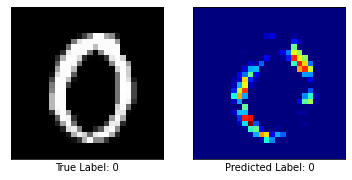

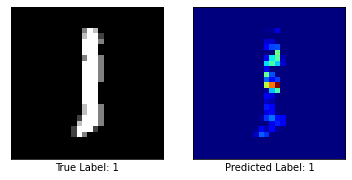

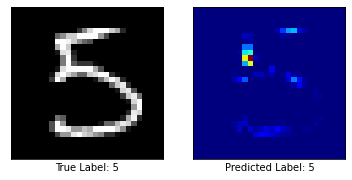

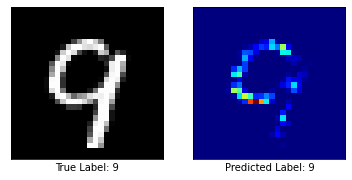

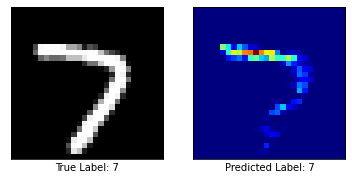

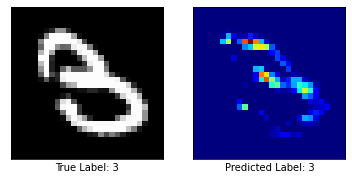

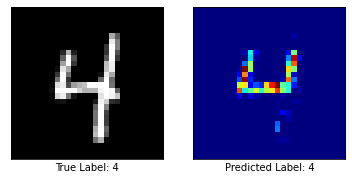

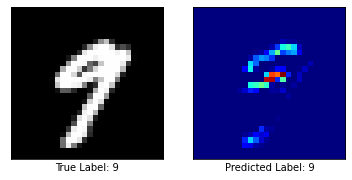

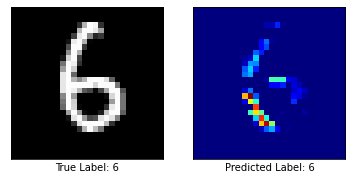

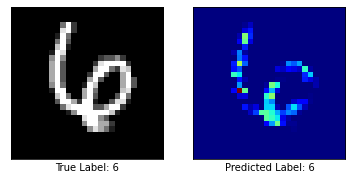

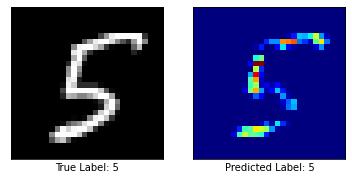

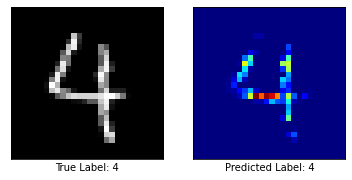

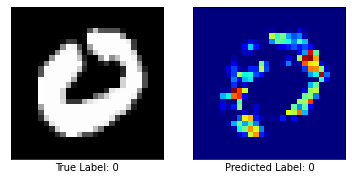

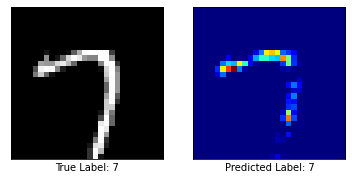

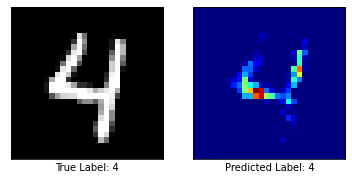

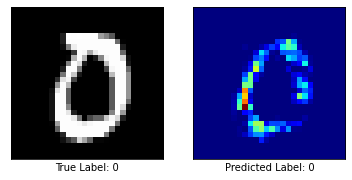

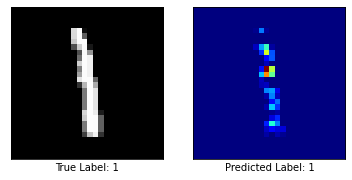

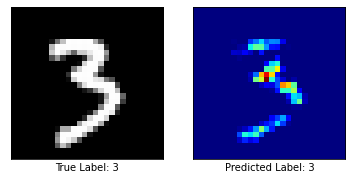

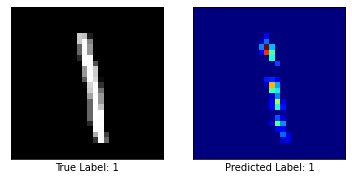

In [ ]:
visualize_ig(igs, x_test, y_test, pred_classes, post_processing=True)

[1] R. R. Selvaraju, M. Cogswell, A. Das, R. Vedantam, D. Parikh and D. Batra, “Grad-cam: Visual explanations from deep networks via gradient-based localization,” in Proceedings of the IEEE international conference on computer vision, 2017, pp. 618–626.

[2] M. Sundararajan, A. Taly and Q. Yan, “Axiomatic attribution for deep networks,” in Proceedings of the 34th International Conference on Machine Learning-Volume 70. JMLR. org, 2017, pp. 3319–3328.